# Imports

In [51]:
import h5py
import os
import napari
import gc
import astra

import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff

from skimage.draw import disk
from scipy.ndimage import label, binary_dilation
from scipy.stats import truncnorm
from tqdm import tqdm

from src.reco_plugin.processing.reconstruction import create_disk_mask, reconstruct_from_sinogram_slice, create_angles
from src.reco_plugin.processing.sinogram import create_sinogram
from src.reco_plugin.processing.phase import get_padding_size_slice, paganin_filter, unsharp_mask

# Functions

In [52]:
def display_2D(data, title=None, cmap='gray', vmin=None, vmax=None, window_size=8, colorbar_state=True):
    """
    Display a 2D image using matplotlib
    """
    if vmin is None or vmax is None:
        vmin, vmax = np.percentile(data, [1, 99])

    if window_size is not None:
        plt.figure(figsize=(window_size,window_size))
    plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    if title:
        plt.title(title)
    if colorbar_state:
        plt.colorbar() 
    plt.axis('off')
    plt.show()


def display_3D(datas, titles=None, cmap='gray', vmin=None, vmax=None):
    """
    Display a 3D image using napari.
    """
    viewer = napari.Viewer()
    for data, title in zip(datas, titles):
        viewer.add_image(data, name=title, colormap=cmap)

In [53]:
def display_plot(
    datas, 
    titles=None, 
    colors=None, 
    title="Plot", 
    xlabel="Index", 
    ylabel="Value", 
    grid_step=10,
    ylim=None,
    percent_clip=None,
    mode="line"
):
    """
    Affiche des séries de données en courbes ou barres verticales.

    Parameters:
    - datas : list of 1D arrays
    - titles : list of str (labels)
    - colors : list of str (matplotlib color codes)
    - title : str (main title)
    - xlabel, ylabel : str
    - grid_step : int (x-axis tick step)
    - ylim : tuple (ymin, ymax)
    - percent_clip : float [0-100], conserve seulement les x% plus petites valeurs
    - mode : 'line' (par défaut) ou 'bar'
    """
    plt.figure(figsize=(10, 6))

    n = len(datas)
    if titles is None:
        titles = [f"Data {i}" for i in range(n)]
    if colors is None:
        colors = [None] * n

    for idx, (data, label, color) in enumerate(zip(datas, titles, colors)):
        if percent_clip is not None:
            threshold = np.percentile(data, percent_clip)
            mask = data <= threshold
            data = np.where(mask, data, np.nan)

        x = np.arange(len(data))
        if mode == "bar":
            plt.bar(x, data, label=label, color=color, alpha=0.7, width=1.0)
        else:
            plt.plot(x, data, label=label, color=color)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if ylim is not None:
        plt.ylim(ylim)

    ax = plt.gca()
    ax.set_xticks(np.arange(0, len(datas[0]), step=grid_step))
    ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 20))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    if titles is not None:
        plt.legend()

    plt.tight_layout()
    plt.show()


In [54]:
def find_datasets_with_dim_3(file, group=None, path="", results=None):
    """
    Find all datasets with 3 dimensions in a HDF5 file.       
    """

    
    if results is None:
        results = []

    if group is None:
        group = file

    for key in group:
        item = group[key]
        current_path = f"{path}/{key}"
        if isinstance(item, h5py.Group):
            find_datasets_with_dim_3(
                file, group=item, path=current_path, results=results
            )
        elif isinstance(item, h5py.Dataset):
            if len(item.shape) == 3:
                results.append(
                    (current_path, item.shape)
                ) 
    return results

In [55]:
def find_angles_in_dataset(file, nz, group=None, path="", results=None, start_tol=10, end_tol=10):
    """
    Trouve tous les datasets 1D de longueur `nz`, commençant à ~0 et finissant à ~360.
    Retourne également les tableaux de valeurs correspondants.
    """

    if results is None:
        results = []

    if group is None:
        group = file

    for key in group:
        item = group[key]
        current_path = f"{path}/{key}"
        
        if isinstance(item, h5py.Group):
            find_angles_in_dataset(
                file, nz, group=item, path=current_path, results=results,
                start_tol=start_tol, end_tol=end_tol
            )
        elif isinstance(item, h5py.Dataset):
            if item.ndim == 1 and item.shape[0] == nz:
                try:
                    data = item[()]
                    if (
                        abs(data[0] - 0) <= start_tol and
                        abs(data[-1] - 360) <= end_tol
                    ):
                        results.append(data)
                except Exception as e:
                    print(f"Erreur lors de la lecture de {current_path} : {e}")
    return results

In [56]:
def generate_parallel_vec_geometry(num_proj, det_count, angles, center_of_rotation_px):
    """
    Génère les vecteurs ASTRA 'parallel_vec' et retourne la géométrie de projection et la taille du volume.
    """
    
    shift = -(center_of_rotation_px - det_count / 2)

    vectors = np.zeros((num_proj, 6), dtype=np.float32)
    for i in range(num_proj):
        theta = angles[i]
        ray_x = np.sin(theta)
        ray_y = -np.cos(theta)

        d_x = shift * np.cos(theta)
        d_y = shift * np.sin(theta)

        u_x = np.cos(theta)
        u_y = np.sin(theta)

        vectors[i] = [ray_x, ray_y, d_x, d_y, u_x, u_y]

    proj_geom = astra.create_proj_geom('parallel_vec', det_count, vectors)
    vol_size = 2 * int(det_count - center_of_rotation_px)
    vol_geom = astra.create_vol_geom(vol_size, vol_size)

    return proj_geom, vol_geom

import numpy as np

def weighter(data, cor, window_type="hann"):
    """
    Apply gentle weighting to the overlap area (2 * cor) to limit artifacts.
    
    window_type : "hann" ou "linear"
    """
    weighted_zone = int(2 * cor)
    data_w = np.copy(data)
    x = np.linspace(0, 1, weighted_zone)

    if window_type == "hann":
        window = 0.5 * (1 - np.cos(np.pi * x))
    elif window_type == "smoothstep":
        window = x ** 2 * (3 - 2 * x)
    elif window_type == "linear":
        window = x
    else:
        raise ValueError("Unknown window type")

    data_w[:, :weighted_zone] *= window[None, :]
    return data_w

def run_reconstruction(one_slice, proj_geom, vol_geom, pixel_size, algorithm='FBP_CUDA', iterations=1, GPUindex=0, weighter_func=None, cor=None):
    """
    Effectue la reconstruction avec les géométries fournies.
    """

    if weighter_func is not None and cor is not None:
        one_slice = weighter(one_slice, int(cor), weighter_func)

    proj_id = astra.data2d.create('-sino', proj_geom, one_slice)

    rec_id = astra.data2d.create('-vol', vol_geom, 1)

    projector_id = astra.create_projector('cuda', proj_geom, vol_geom)
    _, sino  = astra.create_sino(one_slice, projector_id)

    cfg = astra.astra_dict(algorithm)
    cfg['ProjectionDataId'] = proj_id
    cfg['ReconstructionDataId'] = rec_id

    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, iterations)

    reconstruction = astra.data2d.get(rec_id)

    astra.algorithm.delete(alg_id)
    astra.data2d.delete(proj_id)
    astra.data2d.delete(rec_id)

    return reconstruction * pixel_size * 1e6, sino

def run_reconstruction_3D(volume, proj_geom, vol_geom, pixel_size, algorithm='FBP_CUDA', iterations=1, GPUindex=0, weighter_func=None, cor=None):
    """
    Effectue la reconstruction 3D avec les géométries fournies.
    """

    reconstruction = run_reconstruction(
        volume[:, 0], proj_geom, vol_geom, pixel_size, algorithm=algorithm, iterations=iterations, GPUindex=GPUindex, weighter_func=weighter_func, cor=cor
    )

    reconstruction = np.expand_dims(reconstruction, axis=0)
    for i in tqdm(range(1, volume.shape[1]), desc="Reconstruction 3D"):
        slice_reconstruction, sino = run_reconstruction(
            volume[:, i], proj_geom, vol_geom, pixel_size, algorithm=algorithm, iterations=iterations, GPUindex=GPUindex, weighter_func=weighter_func, cor=cor
        )
        reconstruction = np.concatenate((reconstruction, np.expand_dims(slice_reconstruction, axis=0)), axis=0)

    return reconstruction, sino


In [57]:
def create_disk_mask(data: np.ndarray) -> np.ndarray:
    """
    Create a circular disk mask from a slice.
    """
    if data.ndim == 2:
        height, width = data.shape
    elif data.ndim == 3:
        depth, height, width = data.shape
        
    disk_mask = np.zeros((height, width))
    rr, cc = disk((height // 2, width // 2), (width // 2) - 15)
    disk_mask[rr, cc] = 1

    if data.ndim == 3:
        disk_mask = np.expand_dims(disk_mask, axis=0)
        disk_mask = np.repeat(disk_mask, depth, axis=0)

    return disk_mask

In [58]:
def crop_3D(
    projs: np.ndarray, 
    slice_idx: int, 
    energy: float, 
    effective_pixel_size: float, 
    distance: float, 
) -> np.ndarray:
    """
    Apply Paganin filter only around the requested slice, and return only the central slice.
    """
    margin = get_padding_size_slice(energy, effective_pixel_size, distance)
    h = projs.shape[1]
    start = max(0, slice_idx - margin - 1)
    end = min(h, slice_idx + margin + 2)
    
    projs_crop = np.copy(projs[:, start:end])

    return projs_crop

In [59]:
def get_sinogram_slice(vol, vol_geom, proj_geom):
    """
    Get a sinogram from a 3D dataset slice.
    
    Parameters
    ----------
    slice : 2D numpy.ndarray
        Slice
        
    Returns
    -------
    numpy.ndarray
        2D sinogram.
        
    """
    projector_id = astra.create_projector('cuda', proj_geom, vol_geom)
    _, sino  = astra.create_sino(vol, projector_id)

    return sino

In [60]:
def normalize(data, min_val=0, max_val=1):
    """
    Normalize the data to the range [min_val, max_val].
    """
    data_min = np.min(data)
    data_max = np.max(data)
    
    normalized_data = (data - data_min) / (data_max - data_min)
    
    return normalized_data

In [61]:
def pg_reconstruction(projs, cor):
    if cor is None:
        sinogram = np.swapaxes(projs, 0, 1)
    else:
        sinogram = create_sinogram(projs, int(2 * cor))

    print("Sinogram shape:", sinogram.shape)
    angles = create_angles(sinogram, end=np.pi)
    print("Angles shape:", angles.shape)
    reconstruction = np.zeros((sinogram.shape[0], sinogram.shape[2], sinogram.shape[2]), dtype=np.float32)
    for i in tqdm(range(sinogram.shape[0]), desc="Generating Slices"):
        slice_= reconstruct_from_sinogram_slice(sinogram[i], angles)
        slice_ = unsharp_mask(cp.asarray(slice_), sigma=2, coeff=0.5).get()
        reconstruction[i] = slice_

    return reconstruction, angles, sinogram

def get_pg_sinogram_slice(vol_slice, angles):

    vol_geom = astra.create_vol_geom(vol_slice.shape[1], vol_slice.shape[0])
    proj_geom = astra.create_proj_geom('parallel', 1.0, vol_slice.shape[1], angles)

    projector_id = astra.create_projector('cuda', proj_geom, vol_geom)
    _, sino  = astra.create_sino(vol_slice, projector_id)

    return sino

# Loading Data

In [62]:
projs_path = r"D:\SOLEIL0125\007_wholehead_15M_1\007_wholehead_15M_1\007_wholehead_15M_1.nxs"
dark_path = r"D:\SOLEIL0125\007_wholehead_15M_1\007_wholehead_15M_1\post_dark.nxs"
flat_paths = r"D:\SOLEIL0125\007_wholehead_15M_1\007_wholehead_15M_1\post_ref.nxs"

with h5py.File(projs_path, 'r') as file:
    projs_key = find_datasets_with_dim_3(file)[0][0]
    projs = np.array(file[projs_key])[:, 150:800]
    angles = np.radians(find_angles_in_dataset(file, projs.shape[0])).flatten()
print("Projections shape:", projs.shape)

with h5py.File(dark_path, 'r') as file:
    dark_key = find_datasets_with_dim_3(file)[0][0]
    dark = np.mean(np.array(file[dark_key]), axis=0)[150:800]
print("Dark shape:", dark.shape)

flat = []
with h5py.File(flat_paths, 'r') as file:
    flat_key = find_datasets_with_dim_3(file)[0][0]
    flat = np.mean(np.array(file[flat_key]), axis=0)[150:800]
print("Flat shape:", flat.shape)

print("Angles shape:", angles.shape)

### Free unused variables
del dark_path, flat_paths, projs_key, dark_key, flat_key
_ = gc.collect()

Projections shape: (3200, 650, 1472)
Dark shape: (650, 1472)
Flat shape: (650, 1472)
Angles shape: (3200,)


In [63]:
### Get Center of Rotation from csv file

csv_path = r"C:\Users\clement.capdeville\Documents\GitHub\SOLEIL25\part_info.csv"
part_info = pd.read_csv(csv_path)
filtered_info = part_info.loc[part_info["Path"] == os.path.basename(projs_path).split(".")[0]]
CoR = filtered_info["CoR"].values[0] if not filtered_info.empty else None

print("CoR:", CoR)

### Free unused variables
del csv_path, part_info, filtered_info
_ = gc.collect()

CoR: 96.00930933963464


# General parameters

In [64]:
energy = 40.0 # keV
pixel_size = 12e-6 # m
effective_pixel_size = 12e-6 # m
distance = 1.2 # m

num_proj, det_high, det_count = projs.shape
print("Number of projections:", num_proj)
print("Detector height:", det_high)
print("Detector count:", det_count)

test_slice_num = 470

proj_geom, vol_geom = generate_parallel_vec_geometry(num_proj, det_count, angles, CoR)

Number of projections: 3200
Detector height: 650
Detector count: 1472


# Let the serious business begin

## Preprocessing

In [65]:
projs = (projs - dark) / (flat - dark)

projs = crop_3D(projs, test_slice_num, energy, effective_pixel_size, distance)
# projs = projs[:, 400:450]
det_high, det_count = projs.shape[1:]
print("Projections shape after cropping:", projs.shape)

display_3D([projs], ["Raw Projections"])

Projections shape after cropping: (3200, 5, 1472)


In [66]:
display_3D([projs], ["Raw Projections"])

## Raw Reconstruction

Creating sinograms: 100%|██████████| 5/5 [00:00<00:00, 27.65it/s]


Sinogram shape: (5, 1600, 2752)
Angles shape: (1600,)


Generating Slices: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]


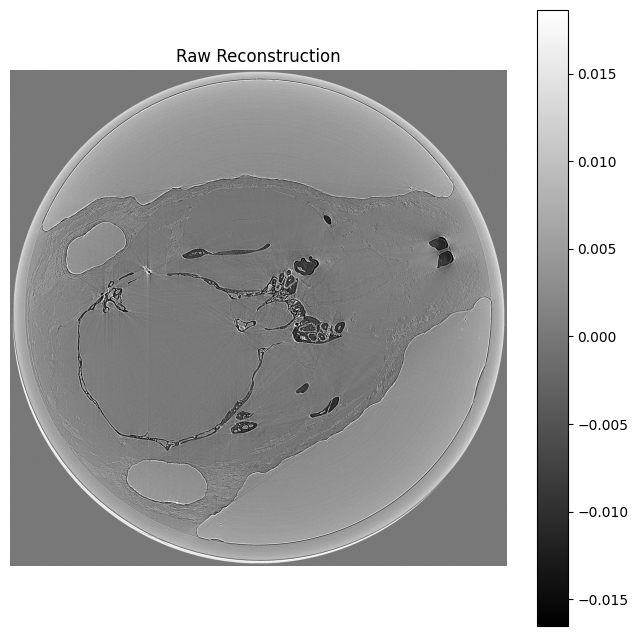

In [67]:
# raw_reconstruction, sino = run_reconstruction_3D(
#     projs, proj_geom, vol_geom, pixel_size, 
#     algorithm='CGLS_CUDA', iterations=100, GPUindex=0,
# )
raw_reconstruction, angles, Sinogram = pg_reconstruction(projs, CoR)

disk_mask = create_disk_mask(raw_reconstruction)
raw_reconstruction *= disk_mask

display_2D(raw_reconstruction[det_high//2], title="Raw Reconstruction", cmap='gray')
display_3D([raw_reconstruction], ["Raw Reconstruction"])

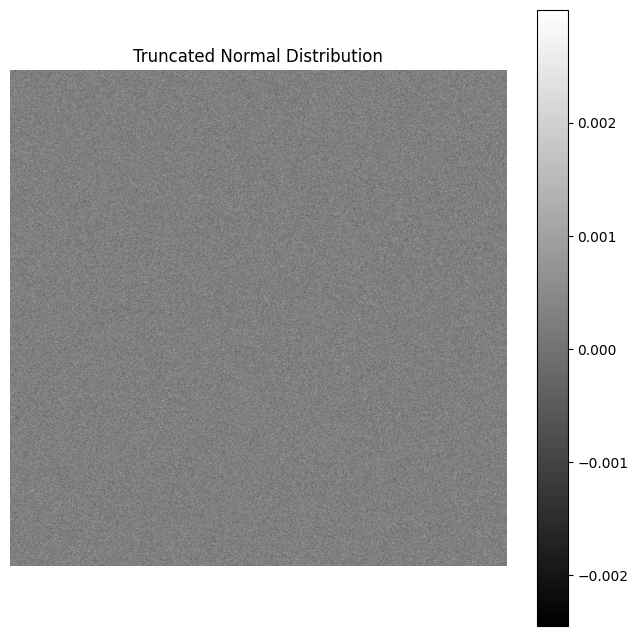

In [68]:
# Paramètres issus de ton histogramme
mean = 0.000276
std = 0.00117
min_val = -0.00653
max_val = 0.00886
shape = raw_reconstruction.shape  # taille de l'image, tu peux l'adapter

# Définir les bornes pour la loi normale tronquée
a, b = (min_val - mean) / std, (max_val - mean) / std

# Génération de la distribution tronquée
truncated_normal = truncnorm(a, b, loc=mean, scale=std)
image = truncated_normal.rvs(size=shape)

display_2D(image[image.shape[0]//2], title="Truncated Normal Distribution", cmap='gray', colorbar_state=True)

## Paganin 1

### Filtering

In [69]:
### New Parameters 

db = 100

In [70]:
### Processing

paganin_proj = paganin_filter(projs, energy, pixel_size, effective_pixel_size, distance, db)['paganin']
# paganin_reconstruction = run_reconstruction_3D(
#     paganin_proj, proj_geom, vol_geom, pixel_size, 
#     algorithm='CGLS_CUDA', iterations=100, GPUindex=0
# ) * disk_mask

paganin_reconstruction, _ = pg_reconstruction(paganin_proj, CoR)
paganin_reconstruction *= disk_mask

display_2D(paganin_reconstruction[det_high//2], title="Paganin Reconstruction", cmap='gray')
display_3D([paganin_reconstruction], ["Paganin Reconstruction"])

Creating sinograms: 100%|██████████| 5/5 [00:00<00:00, 28.27it/s]


Sinogram shape: (5, 1600, 2752)
Angles shape: (1600,)


Generating Slices: 100%|██████████| 5/5 [00:01<00:00,  4.47it/s]


ValueError: too many values to unpack (expected 2)

### Segmentation

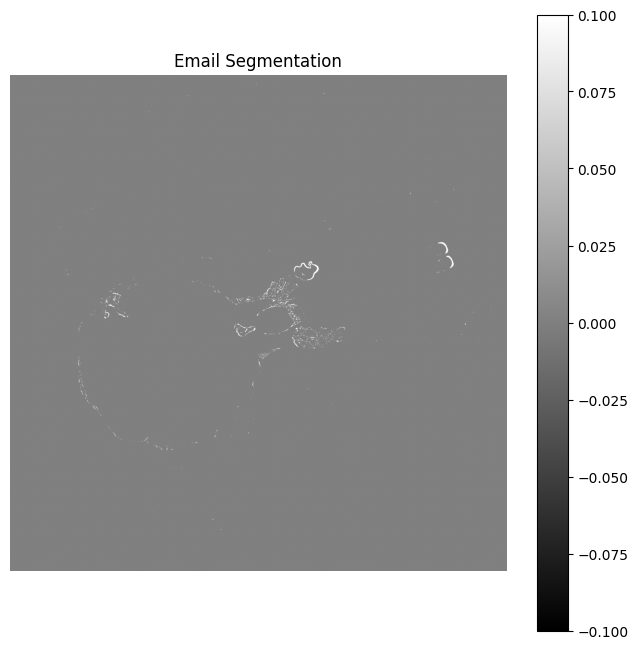

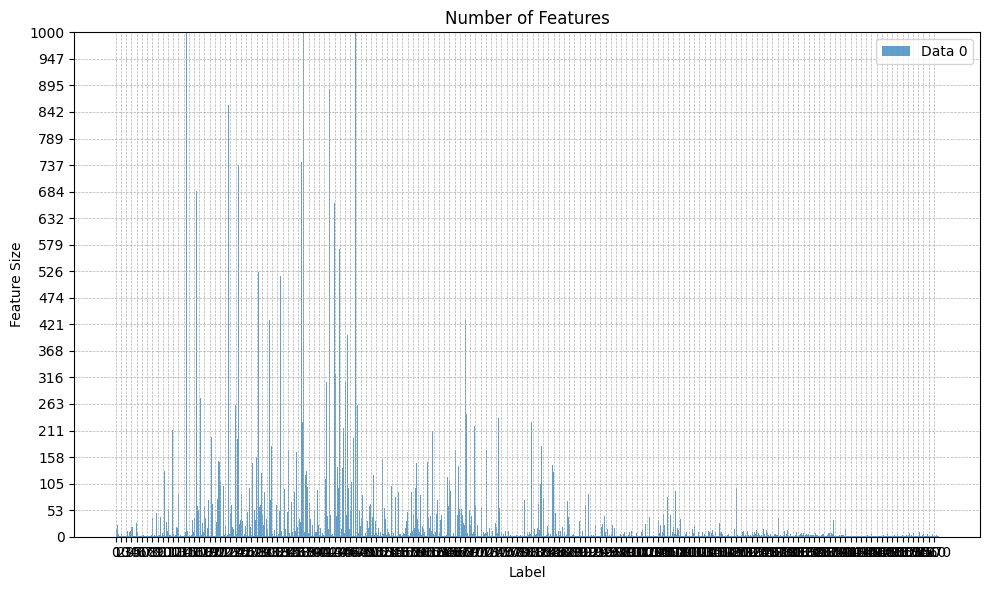

In [ ]:
email = np.where(paganin_reconstruction > 2.2, 1, 0)
display_2D(email[det_high//2], title="Email Segmentation", cmap='gray', colorbar_state=True)

labeled_image, num_features = label(email)
sizes = np.bincount(labeled_image.ravel())[1:]
display_plot([sizes], title="Number of Features", xlabel="Label", ylabel="Feature Size", ylim=(0, 1000), mode="bar")

100%|██████████| 1580/1580 [00:00<00:00, 3824.97it/s]


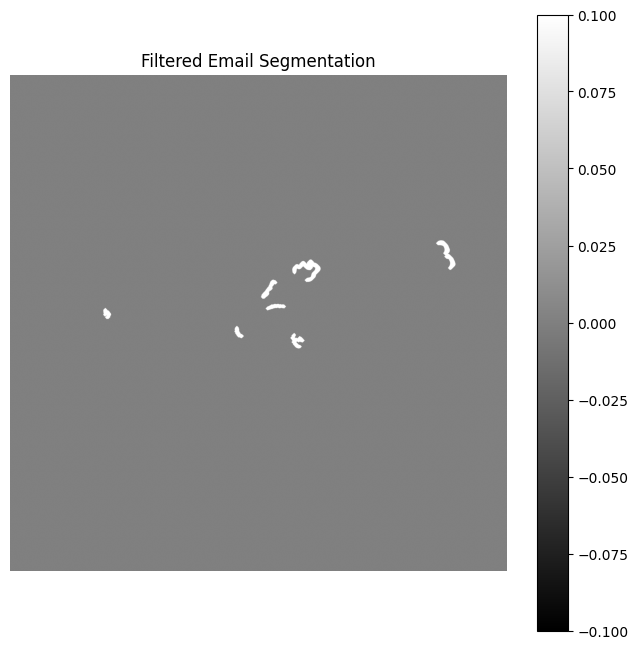

In [ ]:
filtered_label = np.zeros_like(labeled_image, dtype=np.uint8)
for i in tqdm(range(1, num_features + 1)):
    if sizes[i - 1] > 1000:
        filtered_label[labeled_image == i] = 1

filtered_label = binary_dilation(filtered_label, iterations=10)

final_reconstruction = normalize(paganin_reconstruction) * filtered_label

display_2D(final_reconstruction[det_high//2], title="Filtered Email Segmentation", cmap='gray', colorbar_state=True)
display_3D([final_reconstruction], ["Filtered Email Segmentation"])

### Get projections

Getting Porjections: 100%|██████████| 5/5 [00:00<00:00,  6.75it/s]


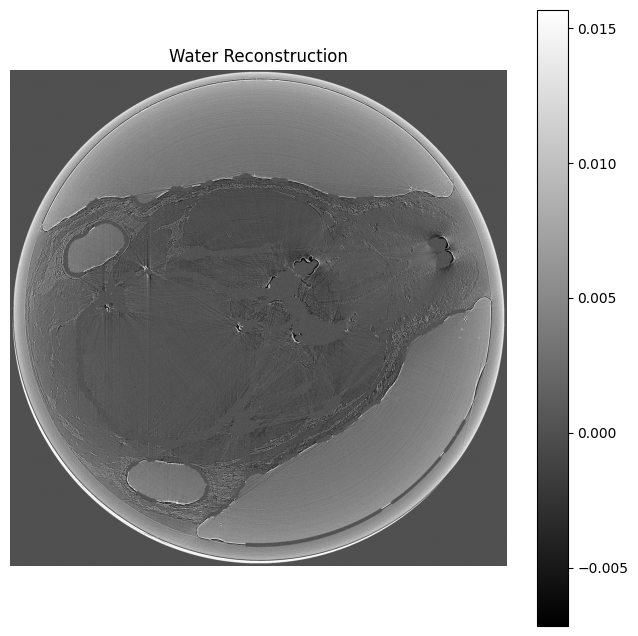

Projections shape: (5, 1600, 2752)


In [ ]:
water_recontruction = np.copy(raw_reconstruction)
water_recontruction[filtered_label != 0] = image[filtered_label != 0]

projs_water = []
# projs_water = np.copy(projs)
for i in tqdm(range(water_recontruction.shape[0]), desc="Getting Porjections"):
    # projs_water[:, i] = get_sinogram_slice(water_recontruction[i], vol_geom, proj_geom)
    projs_water.append(get_pg_sinogram_slice(water_recontruction[i], angles))
projs_water = np.array(projs_water)

display_2D(water_recontruction[det_high//2], title="Water Reconstruction", cmap='gray', colorbar_state=True)
display_3D([water_recontruction, projs_water], ["Water Reconstruction", "Water Projections"])

print("Projections shape:", projs_water.shape)


In [ ]:
# display_3D([projs_water], ["Final 1"])

# test = (1-normalize(projs_water)) * Sinogram

display_3D([test, 1-normalize(projs_water), Sinogram, projs_water2], ["Test", "1-Normalized Projections", "Sinogram", "Projections"])

test_rec, _, _ = pg_reconstruction(paganin_proj, None)

Sinogram shape: (5, 3200, 1472)
Angles shape: (3200,)


Generating Slices: 100%|██████████| 5/5 [00:00<00:00,  5.96it/s]


In [ ]:
display_3D([test_rec], ["Test Reconstruction"])

## Paganin 2

### Filtering

In [ ]:
### New Parameters 

db = 250

Processing Paganin: 100%|██████████| 1600/1600 [00:06<00:00, 242.50it/s]


Sinogram shape: (5, 1600, 2752)
Angles shape: (1600,)


Generating Slices: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


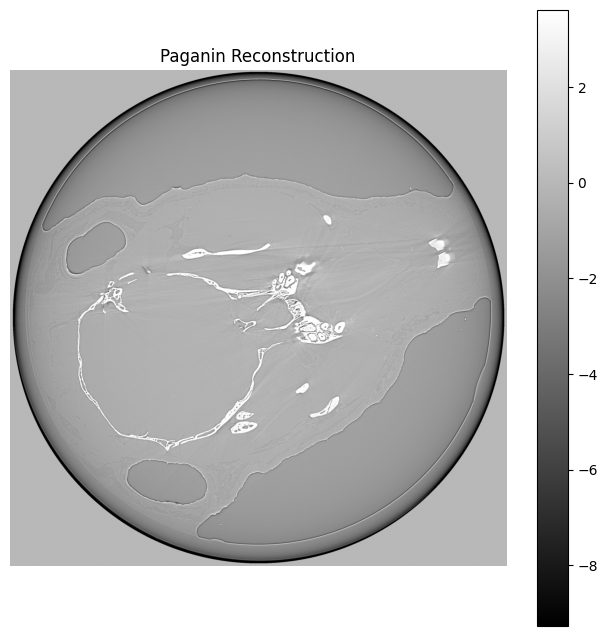

In [ ]:
### Processing

paganin2_proj = paganin_filter(np.swapaxes(projs_water, 0, 1), energy, pixel_size, effective_pixel_size, distance, db)['paganin']
# paganin2_reconstruction = run_reconstruction_3D(
#     paganin2_proj, proj_geom, vol_geom, pixel_size, 
#     algorithm='CGLS_CUDA', iterations=100, GPUindex=0
# ) * disk_mask 
paganin2_reconstruction, _ = pg_reconstruction(paganin2_proj, None) 
paganin2_reconstruction *= disk_mask


display_2D(paganin2_reconstruction[det_high//2], title="Paganin Reconstruction", cmap='gray')
display_3D([paganin2_reconstruction], ["Paganin Reconstruction"])

### Segmentation

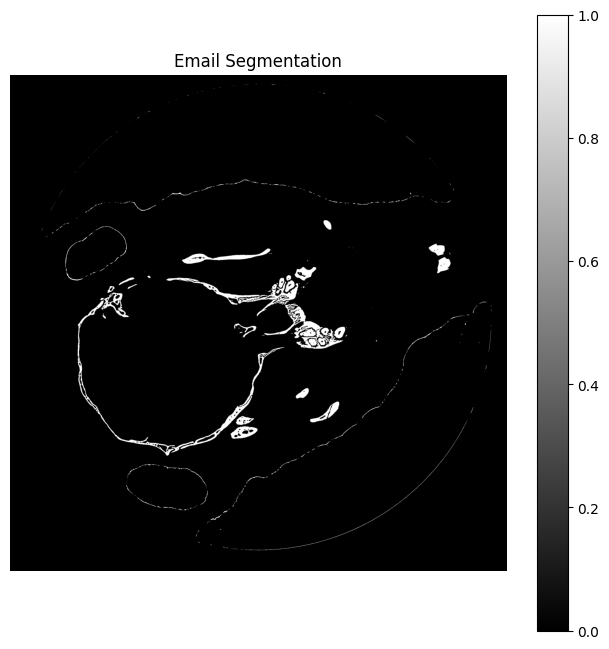

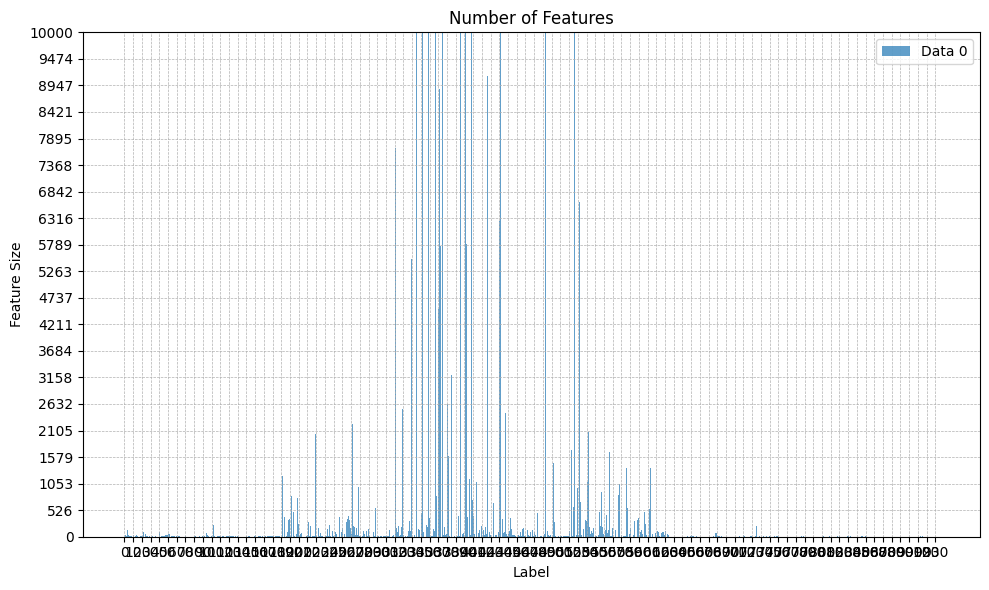

In [ ]:
dentine = np.where(paganin2_reconstruction > 1, 1, 0)
display_2D(dentine[det_high//2], title="Email Segmentation", cmap='gray', colorbar_state=True)

labeled_image, num_features = label(dentine)
sizes = np.bincount(labeled_image.ravel())[1:]
display_plot([sizes], title="Number of Features", xlabel="Label", ylabel="Feature Size", ylim=(0, 10000), mode="bar")

100%|██████████| 935/935 [00:02<00:00, 325.47it/s] 


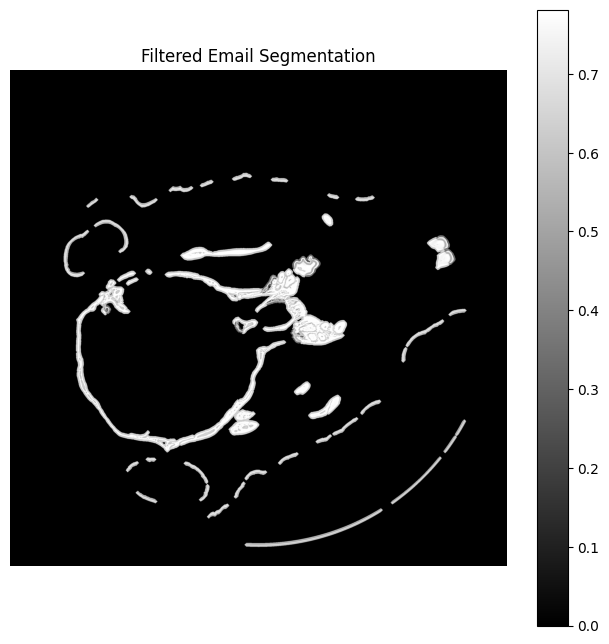

In [ ]:
filtered_label = np.zeros_like(labeled_image, dtype=np.uint8)
for i in tqdm(range(1, num_features + 1)):
    if sizes[i - 1] > 500:
        filtered_label[labeled_image == i] = 1

filtered_label = binary_dilation(filtered_label, iterations=10)

final2_reconstruction = np.copy(final_reconstruction)
final2_reconstruction[final2_reconstruction == 0] = (normalize(paganin2_reconstruction) * filtered_label)[final2_reconstruction == 0]

display_2D(final2_reconstruction[det_high//2], title="Filtered Email Segmentation", cmap='gray', colorbar_state=True)
display_3D([final2_reconstruction], ["Final 2 images"])

In [ ]:
display_3D([final_reconstruction, final2_reconstruction], ["Final 1", "Final 2"])

### Get projections

Getting Porjections: 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]


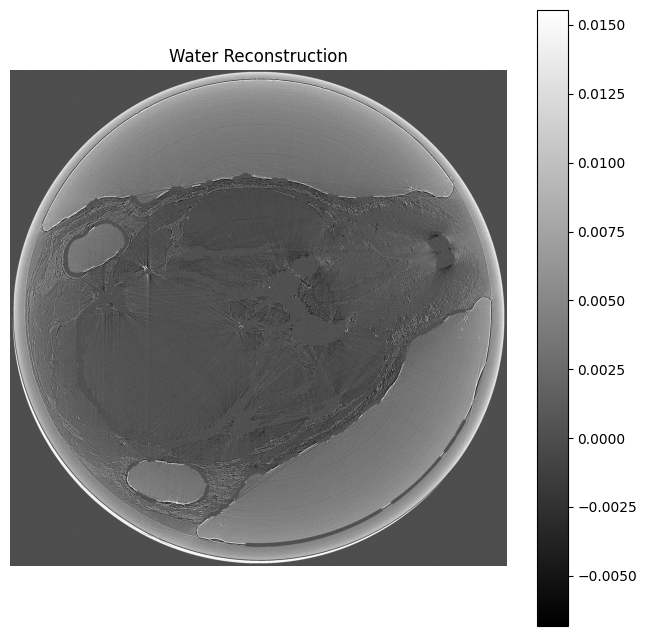

Projections shape: (5, 1600, 2752)


In [ ]:
water2_recontruction = np.copy(water_recontruction)
water2_recontruction[filtered_label != 0] = image[filtered_label != 0]

projs_water = []
# projs_water = np.copy(projs)
for i in tqdm(range(water2_recontruction.shape[0]), desc="Getting Porjections"):
    # projs_water[:, i] = get_sinogram_slice(water_recontruction[i], vol_geom, proj_geom)
    projs_water.append(get_pg_sinogram_slice(water2_recontruction[i], angles))
projs_water = np.array(projs_water)

display_2D(water2_recontruction[det_high//2], title="Water Reconstruction", cmap='gray', colorbar_state=True)
display_3D([water2_recontruction, projs_water], ["Water Reconstruction", "Water Projections"])

print("Projections shape:", projs_water.shape)


## Paganin 3

In [ ]:
### New Parameters 

db = 1000 

Processing Paganin: 100%|██████████| 1600/1600 [00:05<00:00, 269.42it/s]


Sinogram shape: (5, 1600, 2752)
Angles shape: (1600,)


Generating Slices: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]


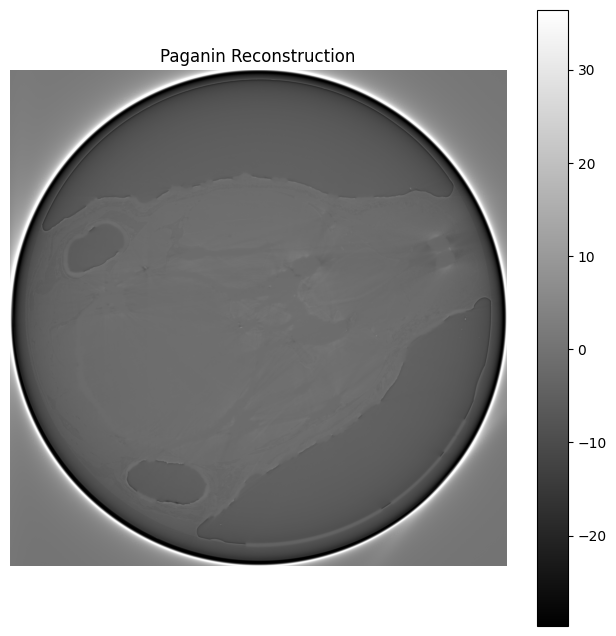

In [ ]:
### Processing

paganin3_proj = paganin_filter(np.swapaxes(projs_water, 0, 1), energy, pixel_size, effective_pixel_size, distance, db)['paganin']
# paganin3_reconstruction = run_reconstruction_3D(
#     paganin3_proj, proj_geom, vol_geom, pixel_size, 
#     algorithm='SIRT_CUDA', iterations=1000, GPUindex=0
# ) * disk_mask 
paganin3_reconstruction, _ = pg_reconstruction(paganin3_proj, None)

display_2D(paganin3_reconstruction[det_high//2], title="Paganin Reconstruction", cmap='gray')
display_3D([paganin3_reconstruction], ["Paganin Reconstruction"])

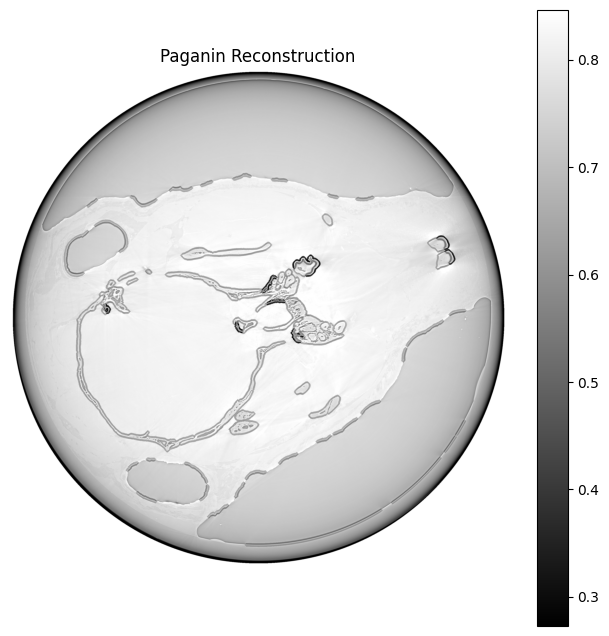

In [ ]:
test = np.copy(paganin3_reconstruction)
test[paganin2_reconstruction == 0] = 0

test = normalize(test)

final3_reconstruction = np.copy(final2_reconstruction)
display_3D([final3_reconstruction], ["Final Reconstruction"])

final3_reconstruction[final3_reconstruction == 0] = test[final3_reconstruction == 0]

display_2D(final3_reconstruction[det_high//2], title="Paganin Reconstruction", cmap='gray')
display_3D([final3_reconstruction], ["Paganin Reconstruction"])

In [ ]:
tiff.imwrite(r"la.tif", final3_reconstruction[det_high//2], imagej=True, metadata={'spacing': [pixel_size, pixel_size, pixel_size]})